# Optimize the Eduati 2020 model using BNMPy optimizer

In the Eduati 2020 paper (doi: 10.15252/msb.209690, link: https://www.ncbi.nlm.nih.gov/pubmed/32073727), 
a logical model has been trained using drug response data to predict new treatment data using the CNOR-ODE tool.   
  
Here, we are trying to optimizie the model using the same data they provided, but with our PBN optimizer.

## Training data
Drug response data was obtained from GitHub repository: https://github.com/saezlab/ModelingMPS/tree/master/data/MIDAS_files

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
sys.path.append('./src')
from BNMPy import PBN, BMatrix, booleanNetwork, vis
from BNMPy.steady_state import SteadyStateCalculator
from Optimizer.experiment_data import ExperimentData
from Optimizer.parameter_optimizer import ParameterOptimizer
from Optimizer.model_compressor import compress_model

network_file = '../input_files/Eduati2020_standardized_no_expand.txt'
data_aspc1_file = '../data/Eduati2020_AsPC1_cleaned.csv'

In [4]:
data_aspc1 = pd.read_csv('../data/Eduati2020_AsPC1.csv')
data_aspc1

TR:AsPC1:CellLine  TR:EGFRi  TR:JAKi  TR:AktPi  TR:PDPK1i  TR:MEKi  \
0                   1         0        0         0          0        0   
1                   1         1        0         0          0        0   
2                   1         0        1         0          0        0   
3                   1         1        1         0          0        0   
4                   1         0        0         1          1        0   
..                ...       ...      ...       ...        ...      ...   
69                  1         0        0         1          1        0   
70                  1         0        0         0          0        1   
71                  1         0        0         0          0        0   
72                  1         0        0         0          0        0   
73                  1         0        0         0          0        0   

    TR:AktMi  TR:IKKsi  TR:PI3Ki  TR:TNF  TR:EGF  DA:ALL   DV:Cas3  
0          0         0         0       0       1       0  0.000000  
1          0         0         0       0       1       0  0.000000  
2          0         0         0       0       1       0  0.000000  
3          0         0         0       0       1       0  0.000000  
4          0         0         0       0       1       0  0.000000  
..       ...       ...       ...     ...     ...     ...       ...  
69         0         0         0       1       1      30  0.317508  
70         0         0         0       1       1      30  0.431260  
71         1         0         0       1       1      30  0.579572  
72         0         1         0       1       1      30  0.532916  
73         0         0         1       1       1      30  0.580771  

[74 rows x 13 columns]

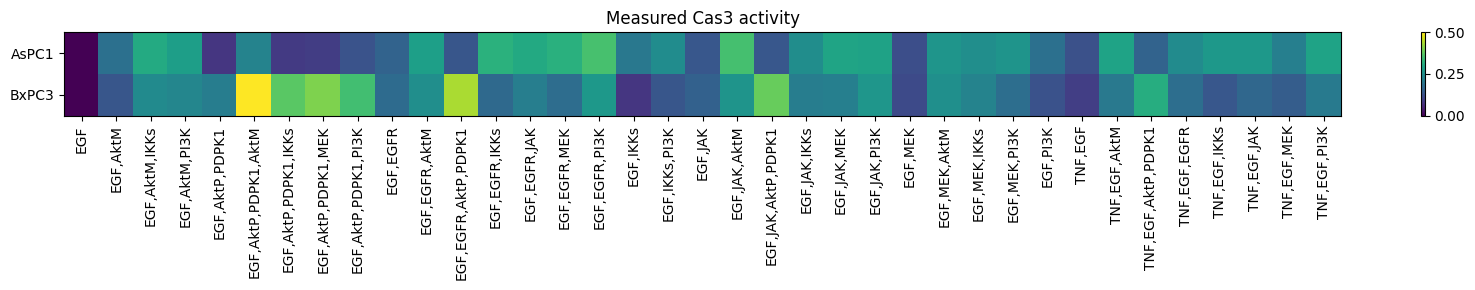

In [30]:
def row_to_condition(row, inhib_cols, stim_cols):
    """Return e.g.  'EGF, EGFRi'  or  'Untreated'."""
    inhibitors = [c.split(':')[-1][:-1]      
                  for c in inhib_cols if row[c] == 1]

    stimuli    = [c.split(':')[-1]    
                  for c in stim_cols if row[c] == 1]

    label = ",".join(stimuli + inhibitors)
    return label if label else "Untreated"

files = {
    "AsPC1": "../data/Eduati2020_AsPC1.csv",
    "BxPC3": "../data/Eduati2020_BxPC3.csv",
}

tidy = []
for cell, f in files.items():
    df = pd.read_csv(f,index_col=0)

    inhib_cols = [c for c in df if c.startswith('TR:') and c.endswith('i')]
    stim_cols  = [c for c in df if c.startswith('TR:') and not c.endswith('i')]

    df['condition'] = df.apply(row_to_condition,
                               axis=1,
                               inhib_cols=inhib_cols,
                               stim_cols=stim_cols)

    cas3 = (df.groupby('condition', sort=False)['DV:Cas3']
              .mean()
              .reset_index())
    cas3['cell_line'] = cell
    tidy.append(cas3)

tidy_df = (pd.concat(tidy)
           .pivot(index='cell_line', columns='condition', values='DV:Cas3'))
           
fig, ax = plt.subplots(figsize=(0.4*tidy_df.shape[1]+2, 3))
im = ax.imshow(tidy_df, aspect="auto")
ax.set_xticks(range(tidy_df.shape[1])); ax.set_xticklabels(tidy_df.columns, rotation=90)
ax.set_yticks(range(tidy_df.shape[0])); ax.set_yticklabels(tidy_df.index)
ax.set_title("Measured Cas3 activity")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

The data was cleaned by changing names of genes to a standard HGNC symbol, and convert to a format that complys with our ExperimentData.

In [13]:
# Load it in BNMPy
data_aspc1 = ExperimentData.load_from_csv(data_aspc1_file)
data_aspc1

[{'id': 1,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': [],
  'inhibitors_efficacy': [],
  'measurements': {'CASP3': 0.0}},
 {'id': 2,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.317699657}},
 {'id': 3,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['JAK1'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.270094786}},
 {'id': 4,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR', 'JAK1'],
  'inhibitors_efficacy': [1.0, 1.0],
  'measurements': {'CASP3': 0.607302371}},
 {'id': 5,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['AktP', 'PDPK1'],
  'inhibitors_efficacy': [1.0, 1.0],
  'measurements': {'CASP3': 0.159653529}},
 {'id': 6,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR', 'AktP', 'PDPK1'],
  'inhibitors_efficacy': [1.0, 1.0, 1.0],
  'measurements': {'CASP3': 

In [5]:
ExperimentData.get_experiment_summary(data_aspc1)

{'num_experiments': 37,
 'unique_stimuli': ['EGF', 'TNF'],
 'unique_inhibitors': ['AktP',
  'EGFR',
  'AktM',
  'JAK1',
  'MAP2K1',
  'IKBKB',
  'PIK3CA',
  'PDPK1'],
 'unique_measured_nodes': ['CASP3'],
 'value_ranges': {'CASP3': {'min': 0.0, 'max': 0.710918524}},
 'stimuli_efficacy_ranges': {'EGF': {'min': 1.0, 'max': 1.0},
  'TNF': {'min': 1.0, 'max': 1.0}},
 'inhibitors_efficacy_ranges': {'EGFR': {'min': 1.0, 'max': 1.0},
  'JAK1': {'min': 1.0, 'max': 1.0},
  'AktP': {'min': 1.0, 'max': 1.0},
  'PDPK1': {'min': 1.0, 'max': 1.0},
  'MAP2K1': {'min': 1.0, 'max': 1.0},
  'AktM': {'min': 1.0, 'max': 1.0},
  'IKBKB': {'min': 1.0, 'max': 1.0},
  'PIK3CA': {'min': 1.0, 'max': 1.0}}}

## Simulate the original model

Consider the mutations in the cell line.  
Mutation profiles for the cell lines are obtained from the GDSC database.

In [45]:
network = BMatrix.load_network_from_file(network_file)

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)
connectivity_matrix = BMatrix.get_connectivity_matrix(equations, upstream_genes, gene_dict)
truth_table = BMatrix.get_truth_table(equations, upstream_genes)
ngenes = len(equations)

# List of cell lines and their mutation profiles
## Obtained from the GDSC database
cell_profiles = {'AsPC1': 'RAS,p53',
                 'BxPC3': 'p53',
                 'Normal': ''}

# Dic file to specify how should the values of the genes be changed when mutated
file_mutations = '../input_files/mutations_Eduati2020.txt'
mutations_dict = BMatrix.get_mutation_dict(file_mutations)
print(f'mutations_dict: {mutations_dict}')

file_perturbations = '../input_files/perturbed_genes_Eduati2020.txt'
perturbations_dict = BMatrix.get_mutation_dict(file_perturbations)
print(f'perturbations_dict: {perturbations_dict}')

No initial state provided, using a random initial state
mutations_dict: {'p53': 0, 'RAS': 1, 'JNKK': 0}
perturbations_dict: {'EGFR': 0, 'JAK': 0, 'Akt': 0, 'PDPK1': 0, 'MEK': 0, 'IKKs': 0, 'PI3K': 0, 'EGF': 1, 'TNF': 1, 'AktP': 0, 'AktM': 0}


In [48]:
## no noise
n = 1000
scores = {}
sim_df = pd.DataFrame()
for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)

    for condition in tidy_df.columns: 
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)
        network = booleanNetwork.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update(n)
        # network_traj = network.update_noise(0.05, 600)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 
        average_array = np.mean(cal_range, axis=0)
        final_score = average_array[gene_dict['Cas3']]
        scores.update({condition: final_score})
    
    df_scores = pd.DataFrame(scores, index=[cell_line])
    sim_df = pd.concat([sim_df, df_scores])

cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF
condition:  EGF,AktM
condition:  EGF,AktM,IKKs
condition:  EGF,AktM,PI3K
condition:  EGF,AktP,PDPK1
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,IKKs
condition:  EGF,AktP,PDPK1,MEK
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,EGFR
condition:  EGF,EGFR,AktM
condition:  EGF,EGFR,AktP,PDPK1
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,PI3K
condition:  EGF,IKKs
condition:  EGF,IKKs,PI3K
condition:  EGF,JAK
condition:  EGF,JAK,AktM
condition:  EGF,JAK,AktP,PDPK1
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,MEK
condition:  EGF,JAK,PI3K
condition:  EGF,MEK
condition:  EGF,MEK,AktM
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,PI3K
condition:  TNF,EGF
condition:  TNF,EGF,AktM
condition:  TNF,EGF,AktP,PDPK1
condition:  TNF,EGF,EGFR
condition:  TNF,EGF,IKKs
condition:  TNF,EGF,JAK
condition:  TNF,EGF,MEK
condition:  TNF,EGF,PI3K
cell line:  BxPC3
m

In [49]:
sim_df

EGF  EGF,AktM  EGF,AktM,IKKs  EGF,AktM,PI3K  EGF,AktP,PDPK1  \
AsPC1   1.0       1.0            1.0            1.0             1.0   
BxPC3   1.0       1.0            1.0            1.0             1.0   
Normal  1.0       1.0            1.0            1.0             1.0   

        EGF,AktP,PDPK1,AktM  EGF,AktP,PDPK1,IKKs  EGF,AktP,PDPK1,MEK  \
AsPC1                   1.0                  1.0                 1.0   
BxPC3                   1.0                  1.0                 1.0   
Normal                  1.0                  1.0                 1.0   

        EGF,AktP,PDPK1,PI3K  EGF,EGFR  ...  EGF,MEK,PI3K  EGF,PI3K  TNF,EGF  \
AsPC1                   1.0       1.0  ...           1.0       1.0      1.0   
BxPC3                   1.0       1.0  ...           1.0       1.0      1.0   
Normal                  1.0       1.0  ...           1.0       1.0      1.0   

        TNF,EGF,AktM  TNF,EGF,AktP,PDPK1  TNF,EGF,EGFR  TNF,EGF,IKKs  \
AsPC1            1.0                 1.0           1.0           1.0   
BxPC3            1.0                 1.0           1.0           1.0   
Normal           1.0                 1.0           1.0           1.0   

        TNF,EGF,JAK  TNF,EGF,MEK  TNF,EGF,PI3K  
AsPC1           1.0          1.0           1.0  
BxPC3           1.0          1.0           1.0  
Normal          1.0          1.0           1.0  

[3 rows x 37 columns]

In [ ]:
# with noise
n = 500000
noise = 0.05
scores = {}
sim_df = pd.DataFrame()
for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)

    for condition in tidy_df.columns: 
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)
        network = booleanNetwork.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        # network_traj = network.update(n)
        network_traj = network.update_noise(noise, n)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 
        average_array = np.mean(cal_range, axis=0)
        final_score = average_array[gene_dict['Cas3']]
        scores.update({condition: final_score})
    
    df_scores = pd.DataFrame(scores, index=[cell_line])
    sim_df = pd.concat([sim_df, df_scores])

cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF
condition:  EGF,AktM
condition:  EGF,AktM,IKKs
condition:  EGF,AktM,PI3K
condition:  EGF,AktP,PDPK1
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,IKKs
condition:  EGF,AktP,PDPK1,MEK
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,EGFR
condition:  EGF,EGFR,AktM
condition:  EGF,EGFR,AktP,PDPK1
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,PI3K
condition:  EGF,IKKs
condition:  EGF,IKKs,PI3K
condition:  EGF,JAK
condition:  EGF,JAK,AktM
condition:  EGF,JAK,AktP,PDPK1
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,MEK
condition:  EGF,JAK,PI3K
condition:  EGF,MEK
condition:  EGF,MEK,AktM
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,PI3K
condition:  TNF,EGF
condition:  TNF,EGF,AktM
condition:  TNF,EGF,AktP,PDPK1
condition:  TNF,EGF,EGFR
condition:  TNF,EGF,IKKs
condition:  TNF,EGF,JAK
condition:  TNF,EGF,MEK
condition:  TNF,EGF,PI3K
cell line:  BxPC3
m

In [57]:
sim_df

EGF  EGF,AktM  EGF,AktM,IKKs  EGF,AktM,PI3K  EGF,AktP,PDPK1  \
AsPC1   0.734044   0.74278       0.749984       0.750028        0.748776   
BxPC3   0.729192   0.73772       0.743628       0.741112        0.741784   
Normal  0.727068   0.73614       0.742456       0.739256        0.739620   

        EGF,AktP,PDPK1,AktM  EGF,AktP,PDPK1,IKKs  EGF,AktP,PDPK1,MEK  \
AsPC1              0.756952             0.753588            0.754732   
BxPC3              0.750792             0.747292            0.748256   
Normal             0.747280             0.749392            0.747408   

        EGF,AktP,PDPK1,PI3K  EGF,EGFR  ...  EGF,MEK,PI3K  EGF,PI3K   TNF,EGF  \
AsPC1              0.754368  0.745828  ...      0.746132  0.742736  0.744008   
BxPC3              0.750464  0.736884  ...      0.739948  0.737592  0.738036   
Normal             0.747532  0.736132  ...      0.739748  0.735800  0.736692   

        TNF,EGF,AktM  TNF,EGF,AktP,PDPK1  TNF,EGF,EGFR  TNF,EGF,IKKs  \
AsPC1       0.745812            0.751776      0.748928      0.751356   
BxPC3       0.745228            0.744328      0.743560      0.741684   
Normal      0.742712            0.747828      0.744388      0.736560   

        TNF,EGF,JAK  TNF,EGF,MEK  TNF,EGF,PI3K  
AsPC1      0.746924     0.750688      0.753176  
BxPC3      0.742624     0.739788      0.746332  
Normal     0.743840     0.746540      0.739752  

[3 rows x 37 columns]

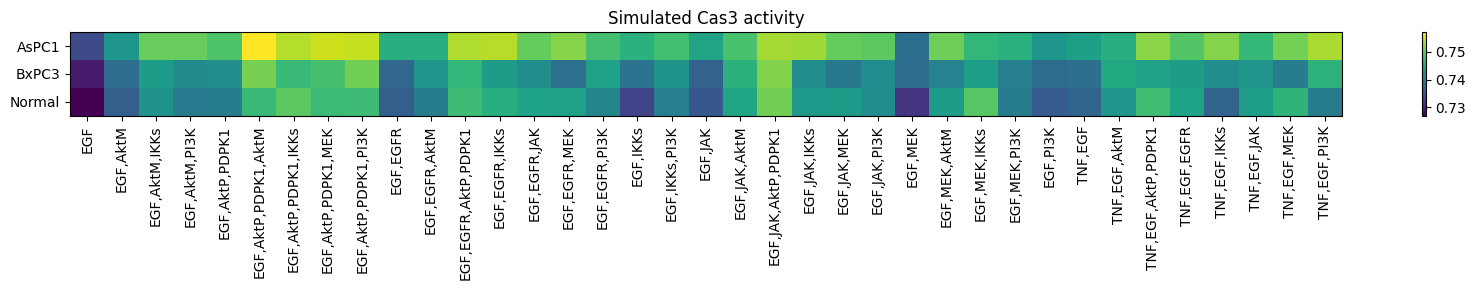

In [58]:
fig, ax = plt.subplots(figsize=(0.4*sim_df.shape[1]+2, 3))
im = ax.imshow(sim_df, aspect="auto")
ax.set_xticks(range(sim_df.shape[1])); ax.set_xticklabels(sim_df.columns, rotation=90)
ax.set_yticks(range(sim_df.shape[0])); ax.set_yticklabels(sim_df.index)
ax.set_title("Simulated Cas3 activity")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Compress the model

In [2]:
measured_nodes, perturbed_nodes = ExperimentData.extract_experiment_nodes(data_aspc1_file)

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 10 perturbed nodes: {'EGF', 'IKBKB', 'AktP', 'PIK3CA', 'PDPK1', 'EGFR', 'MAP2K1', 'AktM', 'JAK1', 'TNF'}


In [3]:
network = BMatrix.load_network_from_file(network_file)

compressed_network, compression_info = compress_model(
    network,
    measured_nodes=measured_nodes,
    perturbed_nodes=perturbed_nodes
)

No initial state provided, using a random initial state
Model Compression Summary:
Removed 0 non-observable nodes
Removed 0 non-controllable nodes
Collapsed 0 linear paths

Total nodes removed/collapsed: 0
Final network size: 46 nodes
Network type: Boolean Network


In [4]:
vis.vis_compression_comparison(
    network,
    compressed_network, 
    compression_info,
    output_html="compression_Eduati2020.html",
    interactive=True,
    measured_nodes=measured_nodes,
    perturbed_nodes=perturbed_nodes
)

Network visualization saved to compression_Eduati2020.html


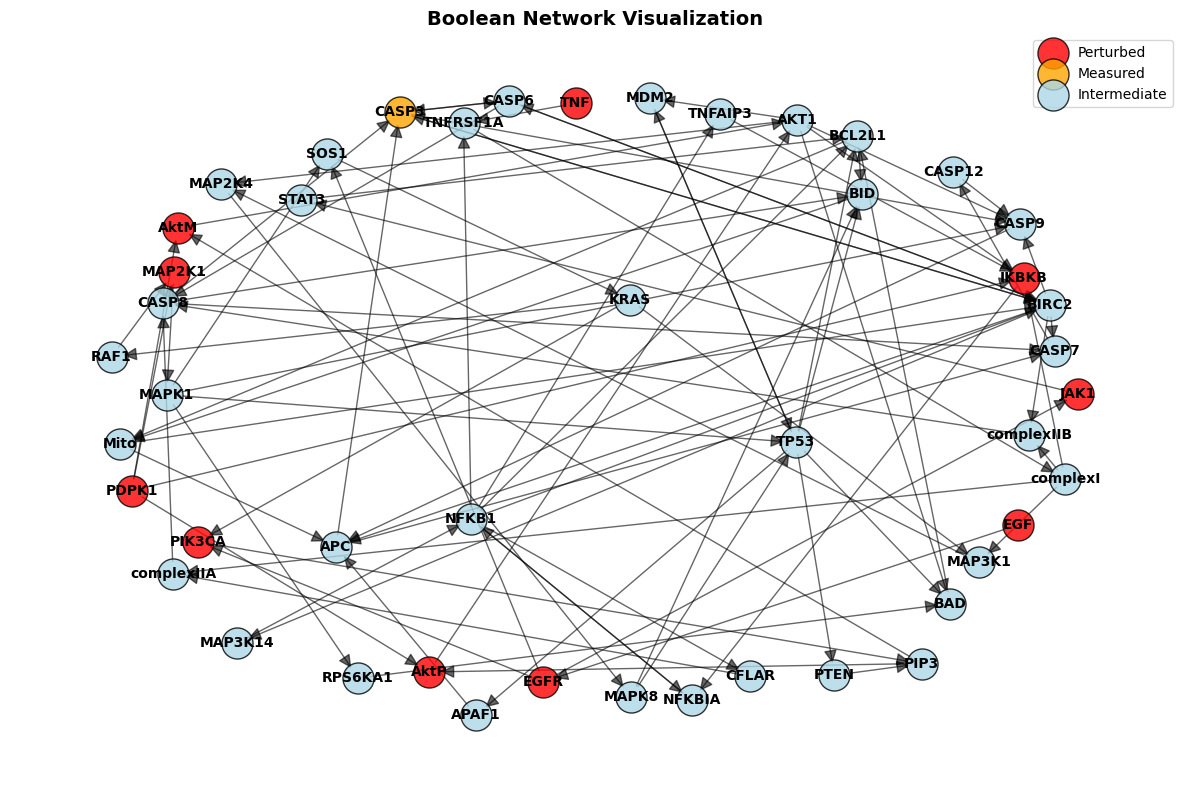

In [5]:
vis.vis_network(compressed_network,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

## Define alternative rule for PBN

We will just use self-loop as the alternative rules for now.  

E.g., for `TNFRSF1A = NFKB1 | TNF` in BN, its rule in PBN will be: 
   
`TNFRSF1A = NFKB1 | TNF, p`  
`TNFRSF1A = TNFRSF1A, 1-p`   
where p is the probability to be optimized. We will just put a 0.5 here as placeholder.

In [7]:
def BN2PBN(bn_string, prob=0.5):
    """
    Expand the boolean network to a PBN by adding a self-loop as alternative function
    prob: probability of the equations from the original BN

    Returns:
        pbn_string: string of the PBN
        nodes_to_optimize: list of nodes excludes input nodes
    """
    # Parse equations from BN
    bn_equations = {}
    for line in bn_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            bn_equations[target.strip()] = rule.strip()
    
    # Expand rules
    pbn_equations = []
    nodes_to_optimize = []

    for target in bn_equations.keys():
        if bn_equations[target] == target:
            # If its already a self-loop (e.g., a input node)
            pbn_equations.append(f"{target} = {bn_equations[target]}, 1")
        else:
            # Add the original rule with a prob
            pbn_equations.append(f"{target} = {bn_equations[target]}, {prob}")
            # Add the alternative rule
            pbn_equations.append(f"{target} = {target}, {round(1-prob,2)}")
            nodes_to_optimize.append(target)
    
    # remove equations with prob = 0
    pbn_equations = [eq for eq in pbn_equations if eq.split(',')[1] != ' 0']
    pbn_string = '\n'.join(pbn_equations)
    return pbn_string, nodes_to_optimize

with open('../input_files/Eduati2020_standardized.txt', 'r') as f:
    bn_string = f.read()

pbn_string, nodes_to_optimize = BN2PBN(bn_string, prob=0.5)
pbn = BMatrix.load_pbn_from_string(pbn_string)

print("PBN string:")
print(pbn_string)

No initial state provided, using a random initial state
PBN string:
EGF = EGF, 1
EGFR = EGF, 0.5
EGFR = EGFR, 0.5
PDPK1 = PDPK1, 1
TNF = TNF, 1
TNFRSF1A = NFKB1 | TNF, 0.5
TNFRSF1A = TNFRSF1A, 0.5
TNFAIP3 = NFKB1, 0.5
TNFAIP3 = TNFAIP3, 0.5
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5
APC = APC, 0.5
AKT1 = AktM & AktP, 0.5
AKT1 = AKT1, 0.5
AktM = PDPK1 & PIP3, 0.5
AktM = AktM, 0.5
AktP = PDPK1 & PIP3, 0.5
AktP = AktP, 0.5
APAF1 = TP53, 0.5
APAF1 = APAF1, 0.5
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5
BAD = BAD, 0.5
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5
BID = BID, 0.5
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5
BCL2L1 = BCL2L1, 0.5
CASP12 = CASP7, 0.5
CASP12 = CASP12, 0.5
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.5
CASP3 = CASP3, 0.5
CASP6 = ! BIRC2 | CASP3, 0.5
CASP6 = CASP6, 0.5
CASP7 = ! BIRC2 | CASP8 | APC, 0.5
CASP7 = CASP7, 0.5
CASP8 = (RIPK1 & TRADD & TRAF2) | ! BIRC2, 0.5
CASP8 = CASP8, 0.5
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.5
CASP9 = CASP9, 0.5
MAPK1 = MA

In [8]:
print(f"There are {len(nodes_to_optimize)} nodes to optimize:")
print(nodes_to_optimize)

There are 44 nodes to optimize:
['EGFR', 'TNFRSF1A', 'TNFAIP3', 'APC', 'AKT1', 'AktM', 'AktP', 'APAF1', 'BAD', 'BID', 'BCL2L1', 'CASP12', 'CASP3', 'CASP6', 'CASP7', 'CASP8', 'CASP9', 'MAPK1', 'IKBKB', 'NFKBIA', 'JAK1', 'MAPK8', 'MAP2K4', 'MAP2K1', 'MAP3K1', 'MDM2', 'Mito', 'NFKB1', 'MAP3K14', 'PIK3CA', 'PIP3', 'PTEN', 'RAF1', 'KRAS', 'RPS6KA1', 'SOS1', 'STAT3', 'CFLAR', 'BIRC2', 'RIPK1', 'TRADD', 'TRAF2', 'FADD', 'TP53']


## PBN steady state test

In [8]:
pbn.nodeDict

{'EGF': 0,
 'EGFR': 1,
 'PDPK1': 2,
 'TNF': 3,
 'TNFRSF1A': 4,
 'TNFAIP3': 5,
 'APC': 6,
 'AKT1': 7,
 'AktM': 8,
 'AktP': 9,
 'APAF1': 10,
 'BAD': 11,
 'BID': 12,
 'BCL2L1': 13,
 'CASP12': 14,
 'CASP3': 15,
 'CASP6': 16,
 'CASP7': 17,
 'CASP8': 18,
 'CASP9': 19,
 'MAPK1': 20,
 'IKBKB': 21,
 'NFKBIA': 22,
 'JAK1': 23,
 'MAPK8': 24,
 'MAP2K4': 25,
 'MAP2K1': 26,
 'MAP3K1': 27,
 'MDM2': 28,
 'Mito': 29,
 'NFKB1': 30,
 'MAP3K14': 31,
 'PIK3CA': 32,
 'PIP3': 33,
 'PTEN': 34,
 'RAF1': 35,
 'KRAS': 36,
 'RPS6KA1': 37,
 'SOS1': 38,
 'STAT3': 39,
 'CFLAR': 40,
 'BIRC2': 41,
 'RIPK1': 42,
 'TRADD': 43,
 'TRAF2': 44,
 'FADD': 45,
 'TP53': 46}

In [6]:
calc = SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['EGF'],inhibitors=['JAK1'])
calc.compute_steady_state(method='monte_carlo',n_runs=3,n_steps=10000,p_noise=0.05)

array([1.        , 0.9381457 , 0.49916683, 0.52222889, 0.68786243,
       0.53262681, 0.51476371, 0.34859695, 0.38712258, 0.38205692,
       0.52742785, 0.88835566, 0.44237819, 0.88442312, 0.74638406,
       0.8741585 , 0.81410385, 0.78184363, 0.43704592, 0.90428581,
       0.50029994, 0.78510964, 0.61840965, 0.        , 0.20602546,
       0.30320603, 0.50029994, 0.61780977, 0.72712124, 0.5234953 ,
       0.53535959, 0.42871426, 0.67753116, 0.70699193, 0.62620809,
       0.66260081, 0.71005799, 0.59114844, 0.89675398, 0.72358862,
       0.51009798, 0.63813904, 0.62440845, 0.48570286, 0.56482037,
       0.4635073 , 0.63553956])

In [ ]:
calc.compute_steady_state(method='tsmc',initial_nsteps=100,max_iterations=5000,freeze_self_loop=False)

In [ ]:
calc.compute_steady_state(method='tsmc',initial_nsteps=100,max_iterations=5000,freeze_self_loop=True)

## Run optimizations for AsPC1 and BxPC3

In [4]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 20*len(nodes_to_optimize),  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': 0.0001,
        'ftol_iter': 10
    },
    'steady_state': {
        # 'method': 'tsmc',
        #     'tsmc_params': {
        #         'epsilon': 0.001, # range of transition probability [Default=0.001]
        #         'r': 0.025, # range of accuracy (most sensitive) [Default=0.025]
        #         's': 0.95, # probability to acquire defined accuracy [Default=0.95]
        #         'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
        #         'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
        #         'max_iterations': 5000, # maximum convergence iterations [Default=5000]
        #         'freeze_self_loop': True # whether to treat self-loop as a fixed node
        #     },
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 10000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.05 # threshold for accepting fit
}

In [5]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-07-05 12:19:47,761 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 0.0001
  - Tolerance iterations: 10




pyswarms.single.global_best:   0%|          |0/1000

  SSE for experiment 1: 0.5929708279499869
  SSE for experiment 2: 0.31861198137986635
  SSE for experiment 3: 0.27781239089031423
  SSE for experiment 4: 0.08895297415166467
  SSE for experiment 5: 0.5312010984147123
  SSE for experiment 6: 0.20388586379993714
  SSE for experiment 7: 0.3933064604412988
  SSE for experiment 8: 0.30368452523262446
  SSE for experiment 9: 0.07117490677935853
  SSE for experiment 10: 0.054150919240575496
  SSE for experiment 11: 0.5172256264094693
  SSE for experiment 12: 0.25727404479533766
  SSE for experiment 13: 0.029477489455292164
  SSE for experiment 14: 0.036627617236009755
  SSE for experiment 15: 0.08751439276161156
  SSE for experiment 16: 0.14121414340624872
  SSE for experiment 17: 0.1597381989328178
  SSE for experiment 18: 0.06743048793687069
  SSE for experiment 19: 0.09761725976857825
  SSE for experiment 20: 0.5344491007814174
  SSE for experiment 21: 0.09813337776793879
  SSE for experiment 22: 0.08334791383318772
  SSE for experiment 2

pyswarms.single.global_best:   0%|          |1/1000, best_cost=5.88

  SSE for experiment 37: 0.10591605654220615

Total SSE: 6.421054156727351
  SSE for experiment 1: 0.6891777457790232
  SSE for experiment 2: 0.2534814795447846
  SSE for experiment 3: 0.3249044014834052
  SSE for experiment 4: 0.0345980959041658
  SSE for experiment 5: 0.41009482199569913
  SSE for experiment 6: 0.17107445214129102
  SSE for experiment 7: 0.3063506966348843
  SSE for experiment 8: 0.34857364456161327
  SSE for experiment 9: 0.03093064607533477
  SSE for experiment 10: 0.04635709564085344
  SSE for experiment 11: 0.38077672966160653
  SSE for experiment 12: 0.1898369818510252
  SSE for experiment 13: 0.016649247242975042
  SSE for experiment 14: 0.01281402871566268
  SSE for experiment 15: 0.06524775176103052
  SSE for experiment 16: 0.07900052089128327
  SSE for experiment 17: 0.18691160614266086
  SSE for experiment 18: 0.030006704485249728
  SSE for experiment 19: 0.18359602510024006
  SSE for experiment 20: 0.4283382781477787
  SSE for experiment 21: 0.130262964508

pyswarms.single.global_best:   0%|          |2/1000, best_cost=5.71

  SSE for experiment 37: 0.1145449312264954

Total SSE: 7.544106601578161
  SSE for experiment 1: 0.7831477273609243
  SSE for experiment 2: 0.24147905947885226
  SSE for experiment 3: 0.4127497596945095
  SSE for experiment 4: 0.04548274866461582
  SSE for experiment 5: 0.4210946875416183
  SSE for experiment 6: 0.25012752125139126
  SSE for experiment 7: 0.2994542699858472
  SSE for experiment 8: 0.45353667219994753
  SSE for experiment 9: 0.03327090305716106
  SSE for experiment 10: 0.11357976507616699
  SSE for experiment 11: 0.40840623492378897
  SSE for experiment 12: 0.19269367150636865
  SSE for experiment 13: 0.04313218636168413
  SSE for experiment 14: 0.012232268568802883
  SSE for experiment 15: 0.10948684941720559
  SSE for experiment 16: 0.0838692836989786
  SSE for experiment 17: 0.26513872662862553
  SSE for experiment 18: 0.031739838517032846
  SSE for experiment 19: 0.18629045005209163
  SSE for experiment 20: 0.42233945839144627
  SSE for experiment 21: 0.18550735889

pyswarms.single.global_best:   0%|          |2/1000, best_cost=5.71


KeyboardInterrupt: 

In [3]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 100,
        'popsize': 15,
        'tol': 0.01, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': True  # Control early stopping
    },
    'steady_state': {
        # 'method': 'tsmc',
        #     'tsmc_params': {
        #         'epsilon': 0.001, # range of transition probability [Default=0.001]
        #         'r': 0.025, # range of accuracy (most sensitive) [Default=0.025]
        #         's': 0.95, # probability to acquire defined accuracy [Default=0.95]
        #         'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
        #         'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
        #         'max_iterations': 5000 # maximum convergence iterations [Default=5000]
        #     },
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 20000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 6,  # An SSE below this is always a success (global)
    'display_rules_every': 1  # Display optimized rules every n iterations (0 = disabled)
    }

In [6]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)
result = optimizer.optimize(method='differential_evolution')


Running optimization using method: differential_evolution
Maximum attempts: 2

--- Attempt 1/2 ---
DE early stopping enabled:
  - Success threshold (SSE): 6
  - Relative tolerance: 0.01



Total SSE: 7.5689776393663175

Total SSE: 7.486075457964242

Total SSE: 6.479539519289982

Total SSE: 7.522663872329394

Total SSE: 7.110552941315173

Total SSE: 8.078813985420195

Total SSE: 7.006881524540307

Total SSE: 5.948156119961955

Total SSE: 7.6059029380105825

Total SSE: 7.736369085728293

Total SSE: 8.049817559240166

Total SSE: 6.78265422049057

Total SSE: 7.073119390372442

Total SSE: 7.255289442397032

Total SSE: 7.602242099646125

Total SSE: 7.349662263605471

Total SSE: 7.574557466727319

Total SSE: 7.8240187461650414

Total SSE: 7.60689669677057

Total SSE: 7.249865540752311

Total SSE: 6.261099210286898

Total SSE: 7.37389867325018

Total SSE: 7.568408376105229

Total SSE: 7.531946736288778

Total SSE: 6.525937080519819

Total SSE: 6.613569914931256

Total SSE: 7.86354291846617

T

KeyboardInterrupt: 